In [1]:
# Import necessary modules
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import sys
import time

from dotenv import load_dotenv
sys.path.insert(0, '..')

from core.genetic_algorithm.ga_bounds import DesignSpaceBounds
from core.genetic_algorithm.ga_params import GeneticAlgorithmParams
from core.genetic_algorithm.ga_run import GeneticAlgorithm

from core.model.model_carrying_capacities import ModelCarryingCapacities
from core.model.model_disturbances import ModelDisturbances
from core.model.model_growth_rates import ModelGrowthRates
from core.model.model_initial_conditions import ModelInitialConditions
from core.model.model_params import ModelParams
from core.model.model_typical_disturbances import ModelTypicalDisturbances

## Model Parameters

In [2]:
# Set ModelParams (time stepping)
model_params = ModelParams(
    dt = 0.1, # hours/step
    simulation_hours = 2900 # hours
)

In [3]:
# Set ModelCarryingCapacities
carrying_capacities = ModelCarryingCapacities(
    kh = 3.0,  # m
    kA = 0.65, # m2
    kN = 20,   # number of leaves
    kc = 1000, # number of spikelets
    kP = 0.25  # kg
)

In [4]:
# Set ModelGrowthRates
growth_rates = ModelGrowthRates(
    ah = 0.01,   # 1/hr
    aA = 0.0105, # 1/hr
    aN = 0.011,  # 1/hr
    ac = 0.01,   # 1/hr
    aP = 0.005   # 1/hr
)

In [5]:
# Set ModelInitialConditions
initial_conditions = ModelInitialConditions(
    h0=carrying_capacities.kh/model_params.simulation_hours, # m/hr
    A0=carrying_capacities.kA/model_params.simulation_hours, # m2/hr
    N0=carrying_capacities.kN/model_params.simulation_hours, # number/hr
    c0=carrying_capacities.kc/model_params.simulation_hours, # number/hr
    P0=carrying_capacities.kP/model_params.simulation_hours  # kg/hr
)

## Design Space

In [6]:
lower_bounds_dict = {
    "irrigation_frequency":    24,     # once every X hours
    "irrigation_amount":       0.001, # inches per irrigation
    "fertilization_frequency": 24,    # once every X hours (once a day)
    "fertilization_amount":    1  # pounds per fertilization
}
lower_bounds = np.array([value for key, value in lower_bounds_dict.items()])

In [7]:
upper_bounds_dict = {
    "irrigation_frequency":    24 * 7 * 10,   # once every 10 weeks
    "irrigation_amount":       1,            # inches per irrigation
    "fertilization_frequency": 30 * 24 * 5,  # once every 5 months
    "fertilization_amount":    300             # pounds per fertilization
}
upper_bounds = np.array([value for key, value in upper_bounds_dict.items()])

In [8]:
# Set DesignSpaceBounds
bounds = DesignSpaceBounds(
    lower_bounds=lower_bounds,
    upper_bounds=upper_bounds
)

## Genetic Algorithm Parameters

In [9]:
# Genetic algorithm style inputs
ga_params = GeneticAlgorithmParams(
    num_parents     = 16,  # number of design strings to breed
    num_kids        = 16,  # number of offspring design strings
    num_generations = 100, # number of generations
    num_members     = 128, # number of simulations per generation
)

## Input Disturbances

In [10]:
# Hourly precipitation, radiation, and temperature from CSV
hourly_input_disturbances = pd.read_csv(
    '../io/inputs/hourly_prcp_rad_temp_iowa.csv',
    header=None,
    names=[
        'Hourly Precipitation (mm)',
        'Hourly Radiation (W/m2)',
        'Temperature (C)'
    ]
)

In [11]:
# Set ModelDisturbances
input_disturbances = ModelDisturbances(
    precipitation = hourly_input_disturbances['Hourly Precipitation (mm)'].to_numpy(),
    radiation     = hourly_input_disturbances['Hourly Radiation (W/m2)'].to_numpy(),
    temperature   = hourly_input_disturbances['Temperature (C)'].to_numpy()
)

## Optimal/Typical Values

In [12]:
typical_disturbances = ModelTypicalDisturbances(
        optimal_cumulative_water      = 28,  # inches/acre per season
        optimal_cumulative_fertilizer = 355, # lbs/acre per season
        typical_temperature           = np.mean(input_disturbances.temperature),   # typical temperature over the season
        typical_radiation             = 3/4 * np.max(input_disturbances.radiation) # typical radiation over the season
    )

## Genetic Algorithm

In [13]:
# Create GeneticAlgorithm object from all inputs
GeneticAlgorithm = GeneticAlgorithm(
    bounds               = bounds,
    ga_params            = ga_params,
    model_params         = model_params,
    carrying_capacities  = carrying_capacities,
    growth_rates         = growth_rates,
    initial_conditions   = initial_conditions,
    disturbances         = input_disturbances,
    typical_disturbances = typical_disturbances
)

In [14]:
# Run the Genetic Algorithm and save the result
GeneticAlgorithmResult = GeneticAlgorithm.run_with_lambda()

with open(f"ga_parallel_result.pkl", "wb") as f:
    pickle.dump(GeneticAlgorithmResult, f)

Time taken to calculate costs for g=0: 2.489001989364624 seconds
Generation 2 of 100
Time to evaluate generation 1: 1.41 s
Generation 3 of 100
Time to evaluate generation 2: 1.43 s
Generation 4 of 100
Time to evaluate generation 3: 1.48 s
Generation 5 of 100
Time to evaluate generation 4: 1.54 s
Generation 6 of 100
Time to evaluate generation 5: 1.38 s
Generation 7 of 100
Time to evaluate generation 6: 1.49 s
Generation 8 of 100
Time to evaluate generation 7: 1.47 s
Generation 9 of 100
Time to evaluate generation 8: 1.46 s
Generation 10 of 100
Time to evaluate generation 9: 1.47 s
Generation 11 of 100
Time to evaluate generation 10: 1.40 s
Generation 12 of 100
Time to evaluate generation 11: 1.48 s
Generation 13 of 100
Time to evaluate generation 12: 1.40 s
Generation 14 of 100
Time to evaluate generation 13: 1.48 s
Generation 15 of 100
Time to evaluate generation 14: 1.46 s
Generation 16 of 100
Time to evaluate generation 15: 1.50 s
Generation 17 of 100
Time to evaluate generation 16:

In [15]:
with open("ga_parallel_result.pkl", "rb") as f:
    result = pickle.load(f)

In [16]:
[unique_values, unique_costs] = result.final_population.get_unique_designs()

Cost for member with values [7.70657630e+02 1.22267002e-01 3.41560371e+03 1.47244859e+00] -- P[-1]: 0.16492970468582419, Expenses: 1.882219449863233, Cost: -732.0549664020544
Cost for member with values [7.70657630e+02 1.22267002e-01 3.41560371e+03 1.47244859e+00] -- P[-1]: 0.16492970468582419, Expenses: 1.882219449863233, Cost: -732.0549664020544
Cost for member with values [7.70657630e+02 1.22267002e-01 3.41560371e+03 1.47244859e+00] -- P[-1]: 0.16492970468582419, Expenses: 1.882219449863233, Cost: -732.0549664020544
Cost for member with values [7.70657630e+02 1.22267002e-01 3.41560371e+03 1.47244859e+00] -- P[-1]: 0.16492970468582419, Expenses: 1.8822194498632343, Cost: -732.0549664020544
Cost for member with values [7.70657630e+02 1.22267002e-01 3.41560371e+03 1.47244859e+00] -- P[-1]: 0.16492970468582419, Expenses: 1.882219449863234, Cost: -732.0549664020544
Cost for member with values [7.70657630e+02 1.22267002e-01 3.41560371e+03 1.47244859e+00] -- P[-1]: 0.16492970468582419, Exp

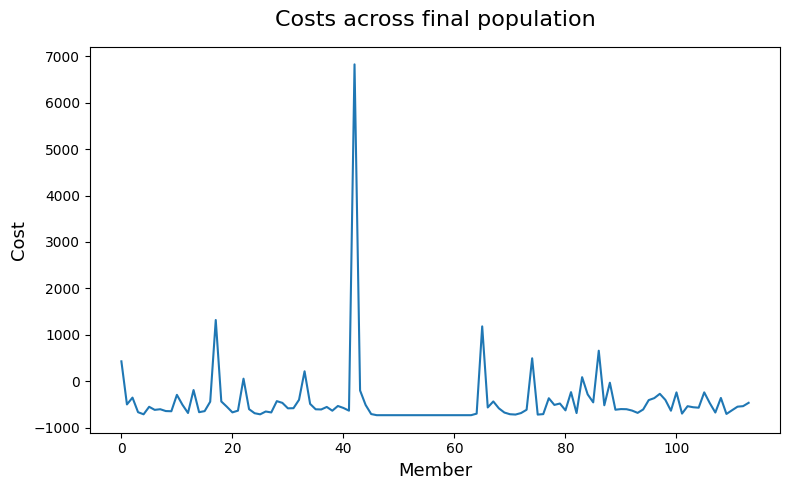

In [17]:
fig, ax = plt.subplots(figsize=(8, 5))

member_ids = np.arange(unique_costs.shape[0])
ax.plot(member_ids, unique_costs)

ax.set_title("Costs across final population", fontsize=16, pad=15)
ax.set_xlabel("Member", fontsize=13)
ax.set_ylabel("Cost", fontsize=13)

fig.tight_layout()

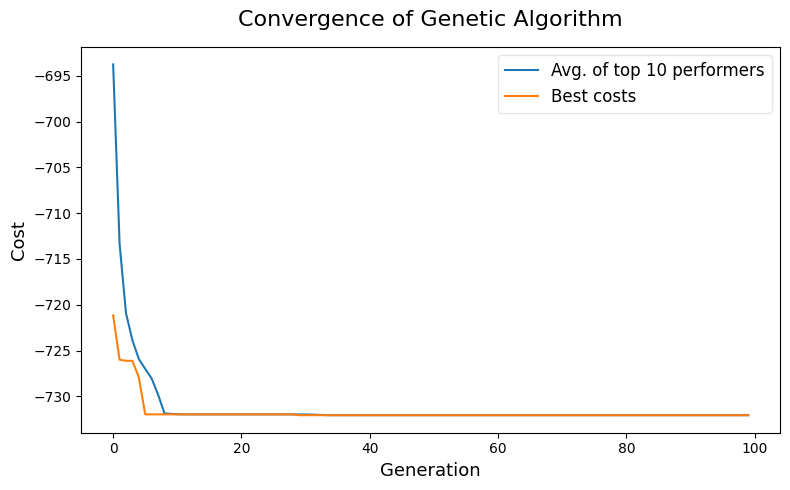

In [18]:
result.plot_optimization_results()

In [20]:
result.get_table_of_best_designs()

Cost for member with values [7.70657630e+02 1.22267002e-01 3.41560371e+03 1.47244859e+00] -- P[-1]: 0.16492970468582419, Expenses: 1.882219449863233, Cost: -732.0549664020544
Cost for member with values [7.70657630e+02 1.22267002e-01 3.41560371e+03 1.47244859e+00] -- P[-1]: 0.16492970468582419, Expenses: 1.882219449863233, Cost: -732.0549664020544
Cost for member with values [7.70657630e+02 1.22267002e-01 3.41560371e+03 1.47244859e+00] -- P[-1]: 0.16492970468582419, Expenses: 1.882219449863233, Cost: -732.0549664020544
Cost for member with values [7.70657630e+02 1.22267002e-01 3.41560371e+03 1.47244859e+00] -- P[-1]: 0.16492970468582419, Expenses: 1.8822194498632343, Cost: -732.0549664020544
Cost for member with values [7.70657630e+02 1.22267002e-01 3.41560371e+03 1.47244859e+00] -- P[-1]: 0.16492970468582419, Expenses: 1.882219449863234, Cost: -732.0549664020544
Cost for member with values [7.70657630e+02 1.22267002e-01 3.41560371e+03 1.47244859e+00] -- P[-1]: 0.16492970468582419, Exp

array([[ 2.71881312e+01,  9.41475727e-01,  1.15632933e+02,
         6.29810153e+01,  4.27933123e+02],
       [ 3.69781812e+01,  7.67978424e-01,  7.91158552e+02,
         4.58123907e+01, -5.00317966e+02],
       [ 3.82046270e+01,  2.15853416e-01,  2.67511108e+03,
         2.83581825e+02, -3.53495329e+02],
       [ 5.41881899e+01,  2.44974018e-01,  1.63373334e+03,
         3.29317893e+01, -6.67586797e+02],
       [ 8.36762899e+01,  6.71104835e-02,  2.93357896e+03,
         2.64068625e+01, -7.13038370e+02],
       [ 1.00527648e+02,  8.51697490e-01,  1.56273426e+03,
         1.08654960e+02, -5.51247060e+02],
       [ 1.06518501e+02,  2.12981049e-01,  2.55493840e+03,
         8.51743645e+01, -6.17474120e+02],
       [ 1.13306508e+02,  8.07825318e-01,  2.94117055e+03,
         1.43664036e+02, -6.03824425e+02],
       [ 1.16578787e+02,  5.74575154e-01,  2.20796791e+03,
         5.04777803e+01, -6.43292471e+02],
       [ 1.18925569e+02,  4.66350622e-01,  2.74060835e+03,
         5.16497459e+01